In [204]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import warnings
import random
import seaborn as sns

warnings.filterwarnings('ignore')

In [205]:
kerasModels = {
    'mlp': 'serialized/keras/mlpModel.keras',
    'lstm': 'serialized/keras/lstmModel.keras',
    'dnn': 'serialized/keras/dnnModel.keras'
}

# Loading a serialized model
model = load_model(kerasModels['dnn'])

In [206]:
# New dataset for forecasting
data = {
    'Location': random.choices(['CityA', 'CityB', 'CityC'], k=130),
    'Year': [2023] * 130,
    'Month': random.choices(range(1, 13), k=130),
    'Day': random.choices(range(1, 29), k=130),  # To avoid February issues
    'Hour': random.choices(range(0, 24), k=130),
    'AQI': [random.randint(0, 500) for _ in range(130)],
    'PM2.5': [round(random.uniform(10, 300), 2) for _ in range(130)],
    'PM10': [round(random.uniform(20, 400), 2) for _ in range(130)],
    'O3': [round(random.uniform(5, 150), 2) for _ in range(130)],
    'CO': [round(random.uniform(0.1, 10), 2) for _ in range(130)],
    'SO2': [round(random.uniform(0.5, 50), 2) for _ in range(130)],
    'NO2': [round(random.uniform(1, 100), 2) for _ in range(130)],
}

data = pd.DataFrame(data)
data.head()

,Location,Year,Month,Day,Hour,AQI,PM2.5,PM10,O3,CO,SO2,NO2
0,CityC,2023,10,28,3,469,31.12,250.04,85.43,9.48,40.25,84.45
1,CityB,2023,2,28,11,112,48.03,50.60,105.32,1.77,8.47,35.78
2,CityC,2023,6,23,5,104,293.87,31.07,70.19,1.03,35.52,68.93
3,CityA,2023,1,18,1,355,68.90,37.65,86.78,6.73,10.52,35.22
4,CityB,2023,10,19,3,365,92.27,289.81,64.48,9.03,8.82,56.34


In [207]:
# Label encoding
le = LabelEncoder()
data['LocationNumeric'] = le.fit_transform(data['Location'])
data['Hour'] = le.fit_transform(data['Hour'])

# Convert hours to numeric format
data['Hour'] = data['Hour'].astype(str).str.split(":").str[0].astype(int)

# Feature selection
X_new = data[['LocationNumeric', 'Year', 'Month', 'Day', 'Hour', 'PM2.5', 'PM10', 'O3', 'CO', 'SO2', 'NO2']]
# Data pre-processing
X_new.fillna(X_new.mean(), inplace=True)

In [208]:
# Data scaling (use the same scaler as during training)
scaler = MinMaxScaler()
X_new_scaled = scaler.fit_transform(X_new)

# Transformation for LSTM (add dimension for time series)
X_new_scaled = np.expand_dims(X_new_scaled, axis=2)

In [209]:
# Prognostication
predictions = model.predict(X_new_scaled)

# Decoding of forecasts (classes)
predicted_classes = np.argmax(predictions, axis=1)

# Displaying categories
category_mapping = {
    '0': 'Good',
    '1': 'Moderate',
    '2': 'USG', 
    '3': 'Unhealthy',
    '4': 'Very Unhealthy',
    '5': 'Severe'
}
predicted_categories = [category_mapping[str(cls)] for cls in predicted_classes]

df_full = X_new.copy()
df_full['AQI'] = predicted_classes
df_full['AQI_Ctegories'] = predicted_categories
print("Input data:")
print(df_full)
print("\nProbabilities for each class:")
print(predictions)
print("\nPredicted classes:")
print(predicted_classes)
print("\nPredicted categories:")
print(predicted_categories)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Input data:
     LocationNumeric  Year  Month  Day  Hour   PM2.5    PM10      O3    CO  \
0                  2  2023     10   28     3   31.12  250.04   85.43  9.48   
1                  1  2023      2   28    11   48.03   50.60  105.32  1.77   
2                  2  2023      6   23     5  293.87   31.07   70.19  1.03   
3                  0  2023      1   18     1   68.90   37.65   86.78  6.73   
4                  1  2023     10   19     3   92.27  289.81   64.48  9.03   
..               ...   ...    ...  ...   ...     ...     ...     ...   ...   
125                0  2023      9   13    22  168.32  103.95   30.09  3.03   
126                2  2023      5   26    22  211.54  267.79  127.11  5.95   
127                0  2023      1   10     6   15.98   63.99   39.51  1.95   
128                2  2023     12   15     9  209.35  339.20   94.86  6.18   
129                2  2023      8   18     6   47.70   60.63  119.82  6.28   

       SO2   

<Axes: title={'center': 'Class Distribution of Processed Dataset'}, xlabel='AQI_Ctegories', ylabel='count'>

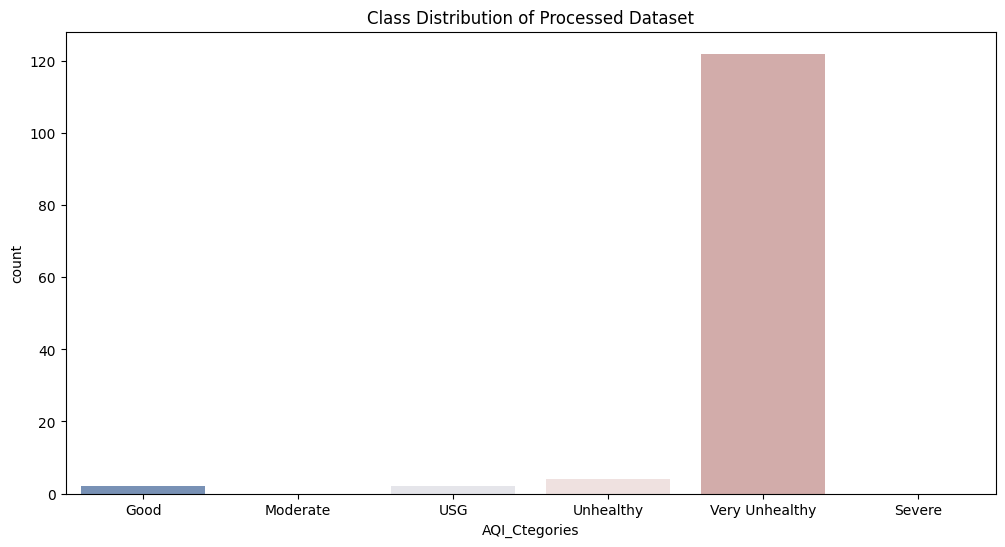

In [210]:
# --- 1. Data Overview ---
# AQI Class Distribution
# Now you can plot the number of changed categories
plt.figure(figsize=(12,6))
plt.title('Class Distribution of Processed Dataset')
custom_order = ['Good', 'Moderate', 'USG', 'Unhealthy', 'Very Unhealthy', 'Severe']
sns.countplot(data=df_full,x='AQI_Ctegories', order=custom_order, palette='vlag')

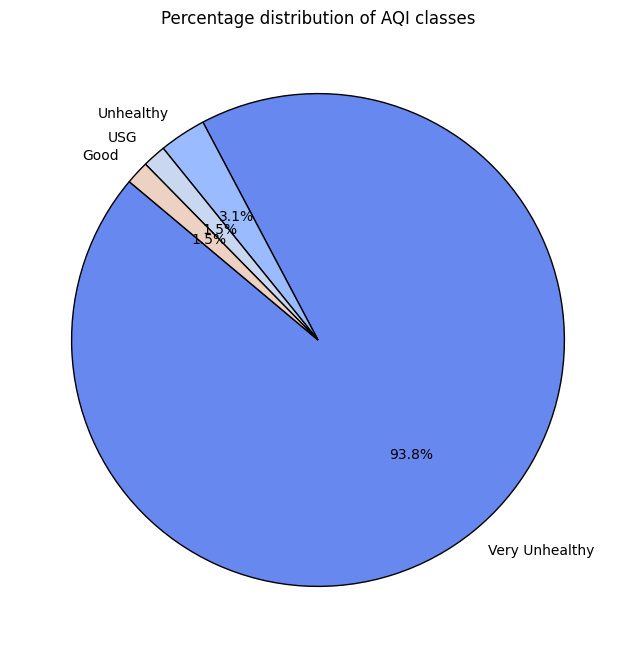

In [211]:
# --- 2. Grouping data by AQI class ---
aqi_class_distribution = df_full['AQI_Ctegories'].value_counts()

# Побудова кругової діаграми
plt.figure(figsize=(8, 8))
aqi_class_distribution.plot.pie(
    autopct='%1.1f%%', 
    startangle=140, 
    colors=sns.color_palette('coolwarm'),
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Percentage distribution of AQI classes')
plt.ylabel('')  # Remove the Y axis label
plt.show()

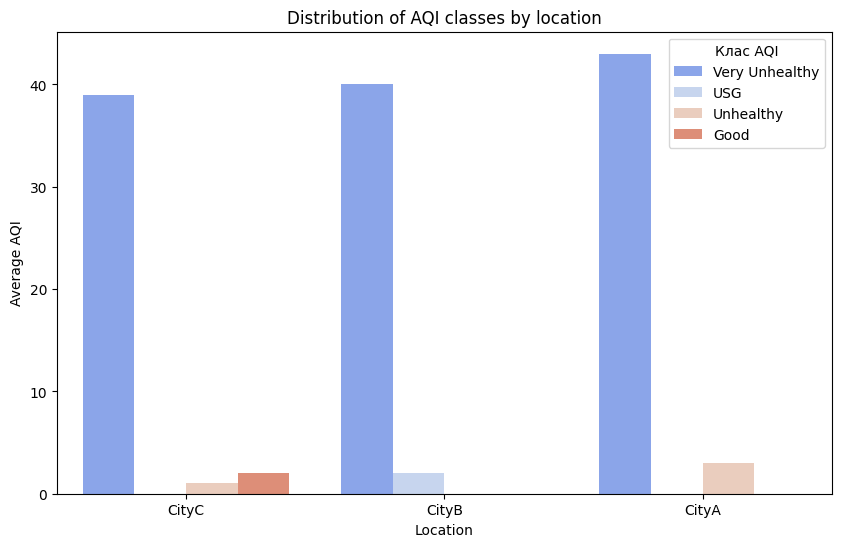

In [212]:
# --- 3. Distribution of AQI classes by location ---
df_full['Location'] = data['Location']
plt.figure(figsize=(10, 6))
sns.countplot(data=df_full, x='Location', hue='AQI_Ctegories', palette='coolwarm')
plt.title('Distribution of AQI classes by location')
plt.xlabel('Location')
plt.ylabel('Average AQI')
plt.legend(title='Клас AQI', loc='upper right')
plt.show()

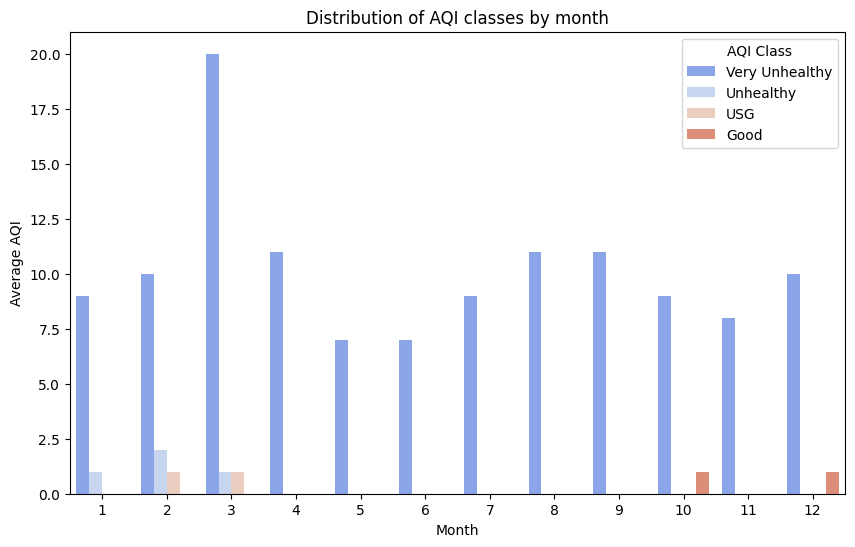

In [213]:
# --- 4. Convert time to hour ---
plt.figure(figsize=(10, 6))
sns.countplot(data=df_full, x='Month', hue='AQI_Ctegories', palette='coolwarm')
plt.title('Distribution of AQI classes by month')
plt.xlabel('Month')
plt.ylabel('Average AQI')
plt.legend(title='AQI Class', loc='upper right')
plt.show()

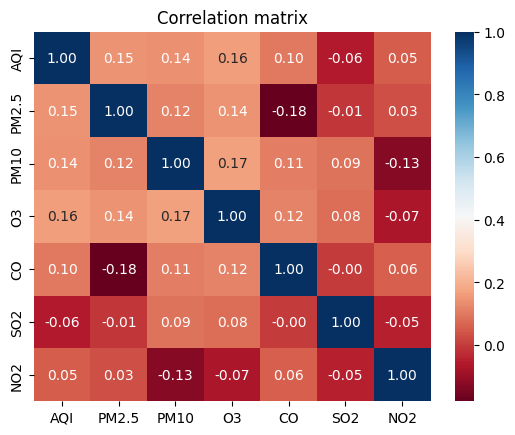

In [214]:
# --- 5. Correlation between variables ---
# Correlation matrix
corr_matrix = data[['AQI', 'PM2.5', 'PM10', 'O3', 'CO', 'SO2', 'NO2']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdBu', fmt=".2f")
plt.title('Correlation matrix')
plt.show()